In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [4]:
df = pd.read_csv("milk_production.csv")
df
# print(type(df.Month))

,Month,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727
...,...,...
163,1975-08,858
164,1975-09,817
165,1975-10,827
166,1975-11,797


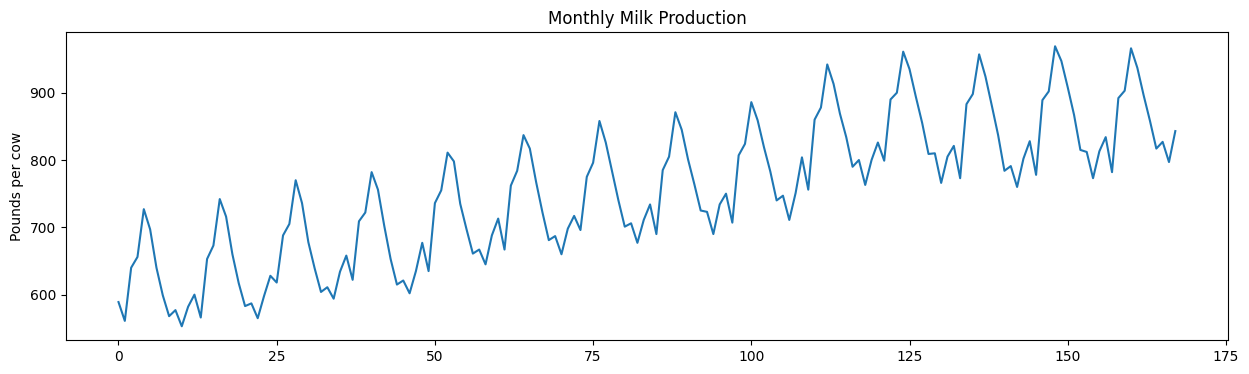

In [5]:
# 3. Convert Month to a datetime index and extract the series
# The 'Month' column has already been set as the index in a previous step,
# so we can directly access the index which is of datetime type.

ts = df['Production']
ts.plot(figsize=(15,4), title="Monthly Milk Production")
plt.ylabel('Pounds per cow')
plt.show()

In [6]:
# 4. Quick stationarity check
from statsmodels.tsa.stattools import adfuller

adf_p = adfuller(ts)[1]
print(f"ADF p-value: {adf_p:.3f}  → {'non-stationary' if adf_p>0.05 else 'stationary'}")

ADF p-value: 0.627  → non-stationary


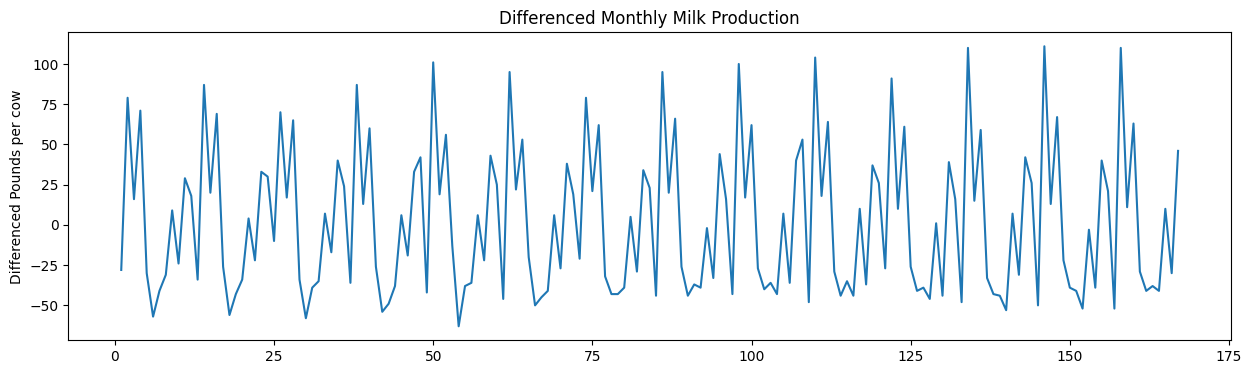

ADF p-value after differencing: 0.030  → stationary


In [11]:
# Since adf_p > 0.05, the series is non-stationary. Let's difference the series to make it stationary.

ts_diff = ts.diff().dropna()

# Plot the differenced series
ts_diff.plot(figsize=(15,4), title="Differenced Monthly Milk Production")
plt.ylabel('Differenced Pounds per cow')
plt.show()

# Check stationarity again
adf_p_diff = adfuller(ts_diff)[1]
print(f"ADF p-value after differencing: {adf_p_diff:.3f}  → {'non-stationary' if adf_p_diff>0.05 else 'stationary'}")

In [41]:
# 5. Use auto_arima() to find best (p,d,q) and seasonal (P,D,Q,12)
from pmdarima import auto_arima
import warnings 
warnings.filterwarnings("ignore")

stepwise_model = auto_arima(
    ts,
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    seasonal=True, m=12,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    d=None, D=1,          # let it infer d, set one seasonal diff
    trace=True, 
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True
)
print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1324.708, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1092.340, Time=1.19 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1211.922, Time=1.78 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1452.434, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1120.381, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1084.671, Time=2.71 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1079.115, Time=4.13 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1077.705, Time=2.42 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1075.731, Time=1.61 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1077.699, Time=2.71 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=1079.724, Time=2.74 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1324.948, Time=1.04 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=1072.066, Time=2.21 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=1118.785, Time=0.60 sec
 ARIMA(2,0,0)(1,1,1

In [38]:
# (p,d,q) and seasonal (P,D,Q,12)
order = stepwise_model.order
seasonal_order = stepwise_model.seasonal_order

In [ ]:
# Fit a non-seasonal ARIMA model using the best (p,d,q) order found by auto_arima
arima_model = ARIMA(ts, order=order)
arima_res = arima_model.fit()
print(arima_res.summary())

In [25]:
# 6. Fit a SARIMAX with those orders for more control

from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(
    ts,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)
print(res.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           Production   No. Observations:                  168
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -490.705
Date:                              Wed, 25 Jun 2025   AIC                            989.410
Time:                                      16:21:48   BIC                           1001.261
Sample:                                           0   HQIC                           994.226
                                              - 168                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7608      0.086      8.818      0.000       0.592       0.930
ar.L2          0.22

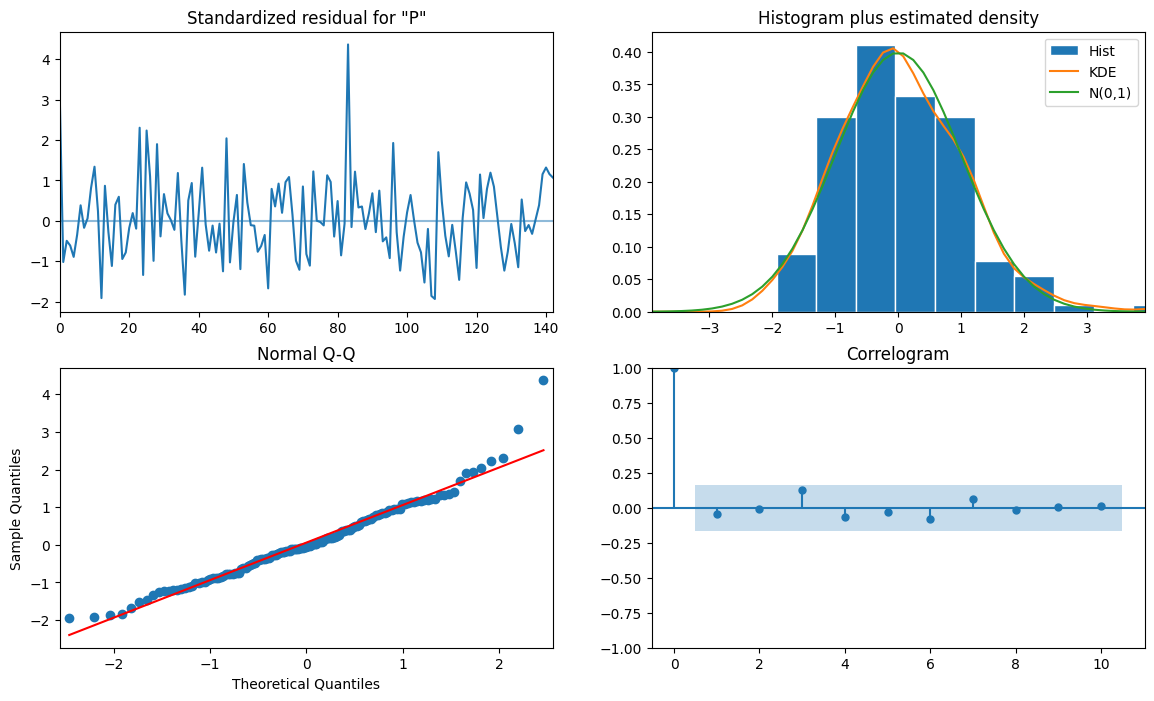

In [26]:
# 7. Diagnostic plots
res.plot_diagnostics(figsize=(14,8))
plt.show()

In [ ]:
# 8. Forecast into the future
n_periods = 20
pred = res.get_forecast(steps=n_periods)
pred_ci = pred.conf_int()

# build a nice DataFrame for plotting
forecast_index = pd.date_range(ts.index[-1] + pd.offsets.MonthBegin(1),
                               periods=n_periods, freq='MS')
fc_series = pd.Series(pred.predicted_mean.values, index=forecast_index)
low_series = pred_ci.iloc[:, 0]
high_series = pred_ci.iloc[:, 1]

# plot history + forecast
plt.figure(figsize=(10,4))
plt.plot(ts, label='Historical')
plt.plot(fc_series, label='Forecast', color='tab:orange')
plt.fill_between(forecast_index, low_series, high_series,
                 color='orange', alpha=0.3)
plt.legend()
plt.title("Milk Production Forecast")
plt.show()

TypeError: unsupported operand type(s) for +: 'int' and 'pandas._libs.tslibs.offsets.MonthBegin'

In [35]:
# 9. (Optional) If you have a hold-out test set, evaluate:
# assume last 24 months were held out

train, test = ts[:-24], ts[-24:]
model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
res2 = model.fit(disp=False)
f2 = res2.get_forecast(steps=24).predicted_mean

from sklearn.metrics import mean_absolute_error, mean_squared_error
print("MAE:", mean_absolute_error(test, f2))
print("RMSE:", mean_squared_error(test, f2, squared=False))

MAE: 8.03957839908613


TypeError: got an unexpected keyword argument 'squared'